In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import string
import os
from collections import defaultdict

pd.set_option("display.max_rows",10)

## Loading data

In [102]:
train = pd.read_csv('train.csv', sep=',', encoding='utf8')
test = pd.read_csv('test.csv', sep=',', encoding='utf8')
print("Training set shape: {} \nTest set shape: {}".format(train.shape, test.shape))

Training set shape: (159571, 8) 
Test set shape: (153164, 2)


In [103]:
n_train = train.shape[0]
n_test = test.shape[0]

In [104]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [105]:
# no missing value
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [106]:
# Checking statistics of the labels in the training set
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [107]:
# number of positive examples for each label
pd.DataFrame(train.iloc[:, 2:8].sum()).transpose()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,15294,1595,8449,478,7877,1405


In [108]:
# more detailed count for different toxic comments

labels = train.columns[2:8].tolist()
grp = train.iloc[:,1:8].groupby(labels)

pd.set_option("display.max_rows",50)
print(grp.count())
pd.set_option("display.max_rows",10)

                                                        comment_text
toxic severe_toxic obscene threat insult identity_hate              
0     0            0       0      0      0                    143346
                                         1                        54
                                  1      0                       301
                                         1                        28
                           1      0      0                        22
                                  1      0                         3
                   1       0      0      0                       317
                                         1                         3
                                  1      0                       181
                                         1                        18
                           1      0      0                         2
                                  1      0                         2
1     0            0       0      

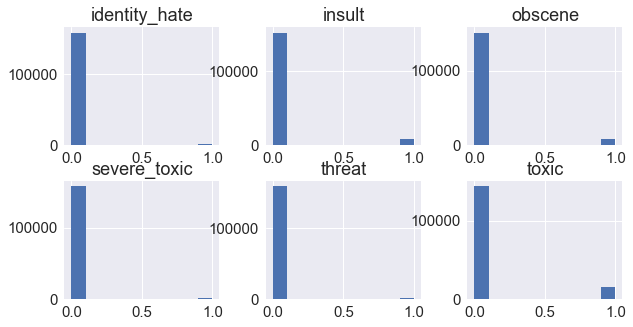

In [109]:
# visuallize the distribution of value for different labels
train.hist(figsize=(10,5), layout=(2,3))
plt.show()

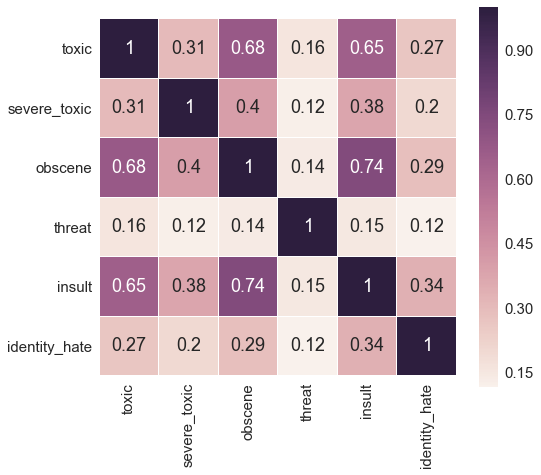

In [110]:
# checking correlation of different lables

plt.figure(figsize=(8,7))
sns.set(font_scale=1.5)
plt.yticks(rotation=0)
sns.heatmap(train.iloc[:,2:].corr(method='spearman'), annot=True, square=True, linewidths=0.1)
plt.show()

## Text preprocessing


In [111]:
full_set = pd.concat([train,test], axis=0, ignore_index=True)
full_set

,comment_text,id,identity_hate,insult,obscene,severe_toxic,threat,toxic
0,Explanation\nWhy the edits made under my usern...,0000997932d777bf,0.0,0.0,0.0,0.0,0.0,0.0
1,D'aww! He matches this background colour I'm s...,000103f0d9cfb60f,0.0,0.0,0.0,0.0,0.0,0.0
2,"Hey man, I'm really not trying to edit war. It...",000113f07ec002fd,0.0,0.0,0.0,0.0,0.0,0.0
3,"""\nMore\nI can't make any real suggestions on ...",0001b41b1c6bb37e,0.0,0.0,0.0,0.0,0.0,0.0
4,"You, sir, are my hero. Any chance you remember...",0001d958c54c6e35,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
312730,". \n i totally agree, this stuff is nothing bu...",fffcd0960ee309b5,NaN,NaN,NaN,NaN,NaN,NaN
312731,== Throw from out field to home plate. == \n\n...,fffd7a9a6eb32c16,NaN,NaN,NaN,NaN,NaN,NaN
312732,""" \n\n == Okinotorishima categories == \n\n I ...",fffda9e8d6fafa9e,NaN,NaN,NaN,NaN,NaN,NaN
312733,""" \n\n == """"One of the founding nations of the...",fffe8f1340a79fc2,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
import spacy
nlp = spacy.load('en_core_web_lg') 

from spacy.tokenizer import Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [113]:
# update punctuation in spacy
nlp.vocab["$"].is_punct = True
nlp.vocab["|"].is_punct = True
nlp.vocab["+"].is_punct = True
nlp.vocab["<"].is_punct = True
nlp.vocab[">"].is_punct = True
nlp.vocab["="].is_punct = True
nlp.vocab["^"].is_punct = True
nlp.vocab["`"].is_punct = True
nlp.vocab["~"].is_punct = True

In [114]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [115]:
def nlp_to_remove(token):
    return(token.is_stop or                                                # remove stop words
           token.is_punct or                                               # reomve punctuations
           token.is_space or                                               # remove white space char
           token.lemma_=='-PRON-'                                          # fixing '-PRON-' issue
           )

def nlp_pip(comment_column, n_cores=cores):
    res = defaultdict(list)
    n = 0
    start_time = time.time()
    for doc in nlp.pipe(comment_column, n_threads=cores):
        filtered_tokens = [token for token in doc if not nlp_to_remove(token)]
        m = len(filtered_tokens)
        if m>0:
            res['caps'].append(sum([token.is_upper for token in filtered_tokens])/m)          # percentage of upper words
            res['longest_word'].append(max([len(token) for token in filtered_tokens]))        # length of the longest word
        else:
            res['caps'].append(0)
            res['longest_word'].append(0)
        lemma_token = [token.lemma_.lower() for token in filtered_tokens]
        res['tokenized'].append(lemma_token)                                                  # list of tokens
        res['cleaned_text'].append(' '.join(lemma_token))                                     # recombined text
        res['len_doc'].append(len(doc))                                                       # number of char
        res['n_words'].append(m)                                                              # number of words
        res['oov'].append(sum([token.is_oov for token in filtered_tokens]))                   # count of out of vocabulary words 
        n += 1
        if n%10000 ==0:
            print("finished {} iterattions, elapsed time: {:.2f} min".format(n, (time.time()-start_time)/60))
    return(res)

def token_to_remove(token):    
    return(token.is_punct or 
           token.is_space or 
           token.lemma_.lower() in nlp.Defaults.stop_words                                   # is_stop not working with lg model
           )
    
def token_pip(comment_column, n_cores=cores):
    res = defaultdict(list)
    n = 0
    start_time = time.time()
    for doc in tokenizer.pipe(comment_column, n_threads=cores):
        filtered_tokens = [token for token in doc if not token_to_remove(token)]
        m = len(filtered_tokens)
        if m>0:
            res['caps'].append(sum([token.is_upper for token in filtered_tokens])/m)          # percentage of upper words
            res['longest_word'].append(max([len(token) for token in filtered_tokens]))        # length of the longest word
        else:
            res['caps'].append(0)
            res['longest_word'].append(0)
        lemma_token = [token.lemma_.lower() for token in filtered_tokens]
#         res['tokenized'].append([token.lemma_.lower() for token in filtered_tokens])        
        res['cleaned_text'].append(' '.join(lemma_token))                                     # recombined text
        res['len_doc'].append(len(doc))                                                       # length of doc
        res['n_words'].append(m)                                                              # number of filtered words
        res['oov'].append(sum([token.is_oov for token in filtered_tokens]))                   # count of out of vocabulary words 
        n += 1
        if n%10000 ==0:
            print("finished {} iterattions, elapsed time: {:.2f} s".format(n, time.time()-start_time))
    return(res)

def token_combine(nested_list):
    combined_doc = []
    for i in range(len(nested_list)):
        combined_doc.append(' '.join(nested_list[i]))
    return(combined_doc)

In [116]:
# takes a few minutes to process

%%time

if not os.path.exists('full_cleaned.pkl') or 0==1:
    print("start processing text...")
    
    # processing url, ip address and punctuations
    full_set.comment_text = full_set.comment_text.apply(lambda x: re.sub(r"(https|http)\S+", "", x))
    full_set.comment_text = full_set.comment_text.apply(lambda x: re.sub(r'[0-9]+(\.[0-9]+){3}', 'ipaddress', x))
    full_set.comment_text = full_set.comment_text.apply(lambda x: re.sub(r'([{}])'.format(string.punctuation),
                                                                         ' \g<1> ', x))  # “”¨«»®´·º½¾¿¡§£₤‘’
    
#     features = nlp_pip(full_set.comment_text)            # this one takes long time
    features = token_pip(full_set.comment_text)      # this one much faster
    for k in features:
        if k=='cleaned_text':
            full_set[k] = features[k]
        else:
            full_set[k] = features[k]/np.std(features[k])    # normalize
    print('Saving dataframe...')
    full_set.to_pickle('full_cleaned.pkl')
else:
    full_set = pd.read_pickle('full_cleaned.pkl')

start processing text...
finished 10000 iterattions, elapsed time: 4.65 s
finished 20000 iterattions, elapsed time: 9.20 s
finished 30000 iterattions, elapsed time: 13.96 s
finished 40000 iterattions, elapsed time: 19.28 s
finished 50000 iterattions, elapsed time: 23.67 s
finished 60000 iterattions, elapsed time: 28.25 s
finished 70000 iterattions, elapsed time: 32.43 s
finished 80000 iterattions, elapsed time: 36.64 s
finished 90000 iterattions, elapsed time: 40.65 s
finished 100000 iterattions, elapsed time: 44.83 s
finished 110000 iterattions, elapsed time: 49.23 s
finished 120000 iterattions, elapsed time: 53.50 s
finished 130000 iterattions, elapsed time: 57.64 s
finished 140000 iterattions, elapsed time: 61.88 s
finished 150000 iterattions, elapsed time: 66.09 s
finished 160000 iterattions, elapsed time: 70.81 s
finished 170000 iterattions, elapsed time: 75.12 s
finished 180000 iterattions, elapsed time: 79.26 s
finished 190000 iterattions, elapsed time: 83.44 s
finished 200000 i

In [117]:
full_set

,comment_text,id,identity_hate,insult,obscene,severe_toxic,threat,toxic,caps,longest_word,cleaned_text,len_doc,n_words,oov
0,Explanation\nWhy the edits made under my usern...,0000997932d777bf,0.0,0.0,0.0,0.0,0.0,0.0,0.271503,0.329716,explanation edit username hardcore metallica f...,0.363484,0.458368,0.000000
1,D ' aww ! He matches this background colour I...,000103f0d9cfb60f,0.0,0.0,0.0,0.0,0.0,0.0,0.905010,0.299741,d aww match background colour seemingly stick ...,0.244412,0.275021,0.000000
2,"Hey man , I ' m really not trying to edit war...",000113f07ec002fd,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.329716,hey man try edit war s guy constantly remove r...,0.332149,0.366694,0.000000
3,""" \nMore\nI can ' t make any real suggestions...",0001b41b1c6bb37e,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.329716,t real suggestion improvement wonder section s...,0.965113,0.898401,0.000000
4,"You , sir , are my hero . Any chance you re...",0001d958c54c6e35,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.239793,sir hero chance remember page s,0.137873,0.110008,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312730,". \n i totally agree , this stuff is nothin...",fffcd0960ee309b5,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.209819,totally agree stuff long crap,0.112805,0.091674,0.000000
312731,= = Throw from out field to home plate . ...,fffd7a9a6eb32c16,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.239793,throw field home plate fast throw cut man dire...,0.319615,0.293356,0.000000
312732,""" \n\n = = Okinotorishima categories = ...",fffda9e8d6fafa9e,NaN,NaN,NaN,NaN,NaN,NaN,0.484827,0.419638,okinotorishima category change agree correct c...,0.827240,0.513372,0.234331
312733,""" \n\n = = "" "" One of the founding nati...",fffe8f1340a79fc2,NaN,NaN,NaN,NaN,NaN,NaN,0.301670,0.329716,found nation eu germany law return similar isr...,0.933778,0.825063,0.078110


**check an example**

In [118]:
# example comment in train set before and after processing

idx = list(train.id).index('001956c382006abd')
print(train.comment_text[idx])
print(full_set.cleaned_text[idx])

I'm Sorry 

I'm sorry I screwed around with someones talk page.  It was very bad to do.  I know how having the templates on their talk page helps you assert your dominance over them.  I know I should bow down to the almighty administrators.  But then again, I'm going to go play outside....with your mom.   76.122.79.82
sorry sorry screw someones talk page bad know template talk page help assert dominance know bow almighty administrator play outside mom ipaddress


In [119]:
# example comment in test set before and after processing

idx2 = 999
print(test.comment_text[idx2])
print(full_set.cleaned_text[n_train+idx2])

FAT KID POOPS IN HIDS MOTHERNESS!!!!!!!! FREE SESSION ON LEARNING HOW TO POOP ON TUESDAYS AT THE PARK WITH A KITTEN WITH POOPNESS!!!!!!!!
fat kid poops hids motherness free session learning poop tuesdays park kitten poopness


**Some more EDA**

In [120]:
# number of unique words in train, test and full set. Large amount of non-overlapping words in train and test set

from itertools import chain
full_words = set(chain(*[text.split() for text in full_set.cleaned_text]))
train_words = set(chain(*[text.split() for text in full_set.cleaned_text[:n_train]]))
test_words = set(chain(*[text.split() for text in full_set.cleaned_text[n_train:]]))
common_words = train_words & test_words
print('number of unique words in full set: {}'.format(len(full_words)))
print('number of unique words in train set: {}'.format(len(train_words)))
print('number of unique words in test set: {}'.format(len(test_words)))
print('number of unique words in both train and test set: {}'.format(len(common_words)))

number of unique words in full set: 339501
number of unique words in train set: 173819
number of unique words in test set: 239113
number of unique words in both train and test set: 73431


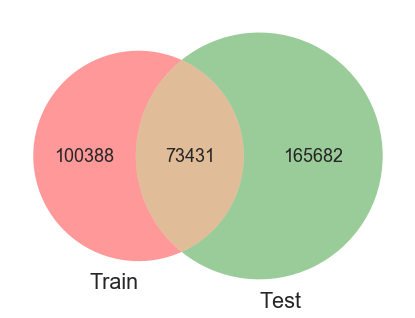

In [121]:
# visuallize the overlapping unique words in train and test set

from matplotlib_venn import venn2

venn2(subsets = (173819-73431, 239113-73431, 73431), set_labels = ('Train', 'Test'))
plt.show()

In [122]:
# Majority of the words in toxic comments are common words also in test set. There are still ~27% words
# in toxic train comments, but not seen in test comments
# using features by tfidf with analyzer='char' should help to reduce this problem

toxic_comments_idx = train.iloc[:,2:8].any(axis=1)
print('Total number of toxic comments in train set: {}'.format(toxic_comments_idx.sum()))
words_in_toxic_comments = set(chain(*[text.split() for text in full_set[:n_train][toxic_comments_idx].cleaned_text]))
print('Number of words in toxic comments: {}'.format(len(words_in_toxic_comments)))
print('-'*50)
print('Number of common words in toxic comments: {}'.format(len(words_in_toxic_comments & common_words)))
print('Number of train only words in toxic comments: {}'.format(len(words_in_toxic_comments & (train_words - common_words))))

Total number of toxic comments in train set: 16225
Number of words in toxic comments: 30847
--------------------------------------------------
Number of common words in toxic comments: 22285
Number of train only words in toxic comments: 8562


In [123]:
# frequent words in toxic comments:

from collections import Counter
toxic_word_freq = Counter(list(chain(*[text.split() for text in full_set[:n_train][toxic_comments_idx].cleaned_text])))

In [124]:
toxic_word_freq.most_common(1000)[-50:]

[('oi', 70),
 ('bill', 70),
 ('culture', 69),
 ('male', 69),
 ('advice', 69),
 ('wife', 69),
 ('date', 69),
 ('basically', 69),
 ('angry', 69),
 ('lady', 69),
 ('bestfrozen', 69),
 ('red', 69),
 ('vuvuzelas', 69),
 ('disruptive', 68),
 ('dispute', 68),
 ('gg', 68),
 ('share', 68),
 ('medium', 68),
 ('effort', 68),
 ('offend', 68),
 ('actual', 68),
 ('18', 68),
 ('uncivil', 68),
 ('controversial', 68),
 ('sup', 68),
 ('recent', 67),
 ('islam', 67),
 ('goodbye', 67),
 ('land', 67),
 ('motherfucking', 67),
 ('father', 67),
 ('star', 67),
 ('theory', 67),
 ('multiple', 67),
 ('thousand', 67),
 ('purpose', 67),
 ('figure', 67),
 ('npov', 67),
 ('lead', 67),
 ('position', 67),
 ('team', 67),
 ('vote', 67),
 ('repeatedly', 67),
 ('result', 67),
 ('billj', 67),
 ('lolooolbootstoots', 67),
 ('jump', 66),
 ('neutral', 66),
 ('situation', 66),
 ('honestly', 66)]

In [125]:
# Checking features generated
full_set.iloc[:, 8:].describe()

,caps,longest_word,len_doc,n_words,oov
count,312735.000000,312735.000000,312735.000000,312735.000000,312735.000000
mean,0.349168,0.326700,0.601420,0.574276,0.115535
std,1.000002,1.000002,1.000002,1.000002,1.000002
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.269767,0.150407,0.128343,0.000000
50%,0.000000,0.299741,0.319615,0.293356,0.000000
75%,0.282816,0.359690,0.651765,0.605046,0.078110
max,6.787576,148.521895,62.256054,35.991060,96.153690


In [126]:
# comments that are all uppercase words
full_set[full_set.caps>6]

,comment_text,id,identity_hate,insult,obscene,severe_toxic,threat,toxic,caps,longest_word,cleaned_text,len_doc,n_words,oov
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,0002bcb3da6cb337,0.0,1.0,1.0,1.0,0.0,1.0,6.787576,0.299741,cocksucker piss work,0.050136,0.055004,0.000000
43,"FUCK YOUR FILTHY MOTHER IN THE ASS , DRY !",00190820581d90ce,0.0,1.0,1.0,0.0,0.0,1.0,6.787576,0.179845,fuck filthy mother ass dry,0.068937,0.091674,0.000000
51,GET FUCKED UP . GET FUCKEEED UP . GOT A DRI...,001dc38a83d420cf,0.0,0.0,1.0,0.0,0.0,1.0,6.787576,0.239793,fucked fuckeeed got drink cant fuck fucked m f...,0.263213,0.183347,0.078110
159,""" \n\nUNBLOCK ME OR I ' LL GET MY LAWYERS ON ...",00637960a7ec3436,0.0,0.0,0.0,0.0,0.0,1.0,6.787576,0.419638,unblock ll lawyers blocking constitutional rig...,0.150407,0.146678,0.000000
338,THIS WIIL BE MY LAST USE OF THIS ACOUNT PLEASE...,00d8def7111797e6,0.0,0.0,0.0,0.0,0.0,0.0,6.787576,0.179845,wiil use acount delete,0.094005,0.073339,0.156220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312473,= = YOU SUCK = =,ff8e520038ac36d8,NaN,NaN,NaN,NaN,NaN,NaN,6.787576,0.119897,suck,0.068937,0.018335,0.000000
312479,NIGEL IS A CRAZY IDIOT ! ! !,ff91c3d8a3e34398,NaN,NaN,NaN,NaN,NaN,NaN,6.787576,0.149871,nigel crazy idiot,0.062670,0.055004,0.000000
312524,= = CUNT CUNT CUNT CUNT CUNT CUNT = = ...,ffa53a5948abe71d,NaN,NaN,NaN,NaN,NaN,NaN,6.787576,0.119897,cunt cunt cunt cunt cunt cunt cunt cunt cunt c...,3.039479,7.498902,0.000000
312668,I HATE MILEY CYRUS DDDDDDDDDDDDDD SEE YA SUCKE...,ffe4badc2184252d,NaN,NaN,NaN,NaN,NaN,NaN,6.787576,0.749354,hate miley cyrus dddddddddddddd ya suckersssss...,0.150407,0.256686,0.234331


In [127]:
# comments that ended up with no token after processing
full_set[full_set.n_words==0]

,comment_text,id,identity_hate,insult,obscene,severe_toxic,threat,toxic,caps,longest_word,cleaned_text,len_doc,n_words,oov
627,Seems we both have some .,01ad9cd4eb4a53c3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.037602,0.0,0.0
899,I ' ve just seen that,0278c8c0d71aec70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.037602,0.0,0.0
2009,"No , I ' ve not seen anything .",05729c95eb3dc41c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.062670,0.0,0.0
2407,"Here , here and here .",067638a445ccd93b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.043869,0.0,0.0
5198,Who are you showing it to ?,0dd89223c129d0d4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.043869,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309172,"Well ( * ^ # & % % ) ( @ # you , ...",fa0b49ac1e36b739,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,,0.238145,0.0,0.0
309212,: This has since been done .,fa1d8cdba2cd3ca1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,,0.050136,0.0,0.0
309519,( ),faa0510471f87cb7,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,,0.025068,0.0,0.0
309847,what about as a last name ?,fb2910e8ce01f045,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,,0.043869,0.0,0.0


In [128]:
# abnormal long word
full_set[full_set.longest_word>100]

,comment_text,id,identity_hate,insult,obscene,severe_toxic,threat,toxic,caps,longest_word,cleaned_text,len_doc,n_words,oov
11796,= = U R GAY = = \n\nFUCKFUCKFUCKFUCKFUCKFU...,1f31848ca28571da,1.0,1.0,1.0,1.0,0.0,1.0,6.787576,148.521895,u r gay fuckfuckfuckfuckfuckfuckfuckfuckfuckfu...,0.075204,0.073339,0.078110
34637,shut up you cunt\nWWWWWWWWWWWWWWWWWWWWWWWWWWWW...,5c854590da41ac65,0.0,1.0,1.0,0.0,0.0,1.0,2.262525,124.692449,shut cunt wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww...,0.037602,0.055004,0.078110
36097,Death To Wikipedia ! Down with free Speach ! ...,6076128b2bd25f28,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,147.592697,death wikipedia free speach hjyunnnnnnnnnnnnnn...,0.075204,0.091674,0.078110
40851,Discussion destroying CRAP topic \n\nIt seems ...,6d063d8888c30ce7,0.0,0.0,0.0,0.0,0.0,1.0,1.018136,140.938436,discussion destroy crap topic edit topic prope...,0.394819,0.366694,0.078110
90297,I shall purge this web site of the weak ! \n\...,f1a77465fee65775,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,147.652645,shall purge web site weak hyyuyuyuyuyuyuyuyuyu...,0.075204,0.110008,0.078110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115606,Feel the might of Cyber Apocalypse ! \n\nyyyy...,6a4a92c6631e7b90,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,147.802516,feel cyber apocalypse yyyyyyyyyyyyyyybvgtfrrrr...,0.056403,0.073339,0.078110
172779,= = bitch . = = \n\n vgdfut tey ...,16391569cf25129e,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,135.033530,bitch vgdfut tey fsddfsssssssssssssssssdtrdttt...,0.100271,0.073339,0.156220
221482,= = they suck balls = = \n\n v baaaa...,66feb5cc4b40f0e2,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,148.222154,suck ball v baaaaaaaaabaaaaaaaaabaaaaaaaaabaaa...,0.100271,0.073339,0.078110
257279,Ï äm̈ ä ẅïk̈ïp̈ëd̈ïä üs̈ër̈ . ̈Ï äm̈ ä ẅïk̈ïp̈...,a308c80d9c7b8d97,NaN,NaN,NaN,NaN,NaN,NaN,1.234105,148.162206,ï äm̈ ä ẅïk̈ïp̈ëd̈ïä üs̈ër̈ ̈ï äm̈ ä ẅïk̈ïp̈ëd...,0.081471,0.201682,0.624882


In [132]:
# abnormal number of oov words
full_set[full_set.oov>20]

,comment_text,id,identity_hate,insult,obscene,severe_toxic,threat,toxic,caps,longest_word,cleaned_text,len_doc,n_words,oov
126,"Ahh , Hello Witzeman \n\nipaddress \nSymbols...",00510c3d06745849,0.0,0.0,0.0,0.0,0.0,0.0,1.690222,0.419638,ahh hello witzeman ipaddress symbols ↔ ↑ ↓ ¶ ½...,8.027985,13.989393,24.136060
6572,Sex sex sex sex Sex sex sex sexSex sex sex sex...,118e2e7cd2b30188,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.179845,sex sex sex sex sex sex sex sexsex sex sex sex...,6.273234,18.353057,25.932595
53408,BunkSteve is gay ! BunkSteve is gay ! BunkSt...,8ecc71e2dd4e2fbe,1.0,1.0,0.0,1.0,0.0,1.0,0.000000,0.269767,bunksteve gay bunksteve gay bunksteve gay bunk...,8.698551,10.194106,21.714643
57594,SuPeRTR0LL WiLL LiVe FoReVeR ! iF You DoN ' T...,9a176c24d63a5c60,0.0,1.0,0.0,0.0,1.0,0.0,0.678758,0.299741,supertr0ll live forever don t respect supertr0...,7.006470,9.350709,23.823619
64020,PenIS pennnis pneis pensnsnnienSNsn peNis PenI...,ab53f74f30338528,0.0,0.0,1.0,0.0,0.0,1.0,0.000000,0.449612,penis pennnis pneis pensnsnniensnsn penis peni...,3.290158,9.625729,41.007869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311557,= = اشاره ای مجددا به سری دوم مباحثات اصلاح...,fdfab8c744626646,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.329716,اشاره ای مجددا به سری دوم مباحثات اصلاحاتی دست...,6.768325,19.508145,50.068656
311941,= = اتحاد عملکردی اتحاد سیاسی سیر تاملی حل ...,fea1ffc2a9054e21,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.239793,اتحاد عملکردی اتحاد سیاسی سیر تاملی حل بحران ج...,6.981402,20.168195,53.271175
312123,= = PHCK U A $ $ HOLE PHCK U A $ $ HOLE P...,fef08b01324576bf,NaN,NaN,NaN,NaN,NaN,NaN,6.787576,0.239793,phck u hole phck u hole phck u hole phck u hol...,14.576966,18.206380,26.010706
312133,= = دومین متن مباحثه با موضوع اختصاصی داعش ...,fef5468c148e51d2,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.299741,دومین متن مباحثه با موضوع اختصاصی داعش و اسرائ...,6.812194,19.599818,49.131333


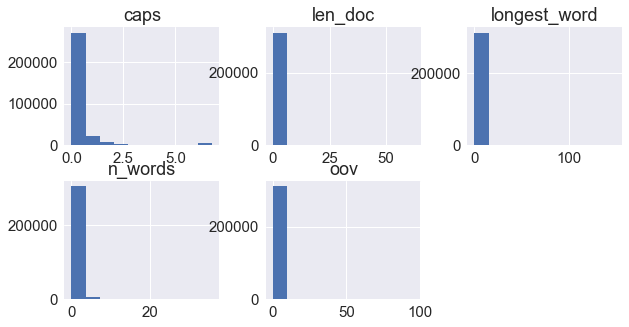

In [133]:
# visuallize the distribution of features
full_set.iloc[:, 8:].hist(figsize=(10,5), layout=(2,3))
plt.show()

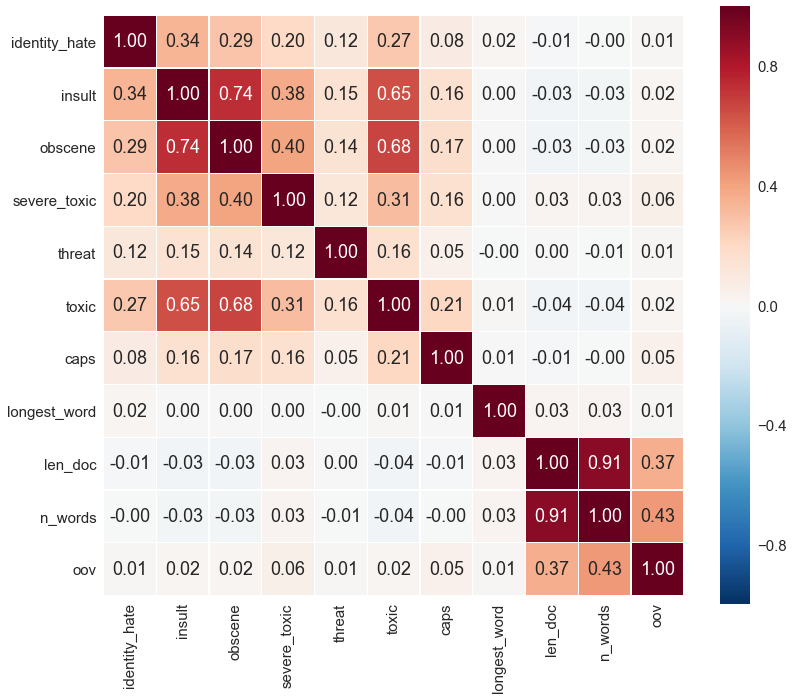

In [134]:
# checking correlation in the train set

plt.figure(figsize=(13,11))
sns.set(font_scale=1.5)
sns.heatmap(full_set.iloc[:n_train,2:].corr(), annot=True, square=True, linewidths=0.1, fmt='.2f')
plt.show()

## comments to vector

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

In [75]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key='comment', idx=None):
        self.key = key
        self.idx = idx

    def fit(self, x, y=None):
        return(self)

    def transform(self, data_dict):
        if self.key == 'comment':
            return(data_dict[self.key])
        elif self.key == 'features':
            print('Select {}x{} previous generated feature matrix'.format(len(self.idx), 
                                                                          data_dict[self.key].shape[1]))
            return(data_dict[self.key].iloc[self.idx,:])

class CommentFeatureExtractor(BaseEstimator, TransformerMixin):
    '''
    input data should contain cleaned comments from both train and test set
    (first n_train samples from train set, the rest from test set), 
    as well as featurs already generated during text preprocessing
    '''
    def __init__(self, n_train=None):
        self.n_train = n_train
        
    def fit(self, x, y=None):
        return(self)

    def transform(self, full_set):
        data = {}
        data['comment'] = full_set.cleaned_text
        data['features'] = full_set.drop('cleaned_text',axis=1)[:self.n_train]
        print('Extracted {} comments and {} feature matrix'.format(len(data['comment']), data['features'].shape))
        return(data)

class MyTfidf(BaseEstimator, TransformerMixin):
    def __init__(self, max_df=1.0, min_df=1, max_features=None, idx=None, analyzer='word'):
        self.max_df = max_df
        self.min_df = min_df
        self.max_features = max_features
        self.idx = idx
        self.analyzer = analyzer
        
    def fit(self, x, y=None):
        return(self)
    
    def transform(self, comments):
        if self.analyzer == 'word':
            ngram_range=(1, 1)
        elif self.analyzer == 'char':
            ngram_range=(1, 4)
        vectorizer = TfidfVectorizer(max_df=self.max_df, ngram_range=ngram_range, min_df=self.min_df, 
                                          max_features=self.max_features, analyzer=self.analyzer,)
        matrix = vectorizer.fit_transform(comments)
        print('Finished tf-idf from {}, shape of generated matrix: {}x{}'.format(self.analyzer, 
                                                                                 len(self.idx), 
                                                                                 matrix.shape[1]))
        return(matrix[self.idx])

In [76]:
x_train, x_test, y_train, y_test, train_idx, test_idx = train_test_split(full_set.cleaned_text[:n_train], 
                                                        full_set['toxic'][:n_train], 
                                                        np.arange(n_train),
                                                        test_size = 0.2, 
                                                        random_state=2018,
                                                        stratify = full_set['toxic'][:n_train])

In [82]:
pip = Pipeline([
            # Extract comments and features columns
            ('commentfeature', CommentFeatureExtractor()),
            
            # use FeatureUnion to combine features from tfidf and other already generated features
            ('union', FeatureUnion(
                transformer_list=[
                    
                    # pipeline to generate features from comments using tfidf analyzed by word
                    ('tfidf_word', Pipeline([
                        ('selector', ItemSelector(key='comment')),
                        ('tfidf', MyTfidf(analyzer='word'))
                    ])),
                    
                    # pipeline to generate features from comments using tfidf analyzed by char
                    ('tfidf_char', Pipeline([
                        ('selector', ItemSelector(key='comment')),
                        ('tfidf', MyTfidf(analyzer='char'))
                    ])),
                    
                    # get other generated features 
                    ('other_features', Pipeline([
                        ('selector', ItemSelector(key='features'))
                    ]))
                ], 
#                 n_jobs=-1,
                transformer_weights={
                    'tfidf_word': 1.0,
                    'tfidf_char': 1.0,
                    'other_features': 1.0,
                }
            )),            
            ])

parameters = {'commentfeature__n_train': n_train,\
              'union__tfidf_word__tfidf__max_df': 1.0,\
              'union__tfidf_word__tfidf__min_df': 50,\
              'union__tfidf_word__tfidf__idx': train_idx,\
              'union__tfidf_char__tfidf__max_df': 1.0,\
              'union__tfidf_char__tfidf__min_df': 50,\
              'union__tfidf_char__tfidf__idx': train_idx,\
              'union__other_features__selector__idx': train_idx,\
              }
pip.set_params(**parameters)

Pipeline(steps=[('commentfeature', CommentFeatureExtractor(n_train=159571)), ('union', FeatureUnion(n_jobs=1,
       transformer_list=[('tfidf_word', Pipeline(steps=[('selector', ItemSelector(idx=None, key='comment')), ('tfidf', MyTfidf(analyzer='word', idx=array([143061,  91099, ...,    356, 123996]),
    m...'))]))],
       transformer_weights={'tfidf_word': 1.0, 'tfidf_char': 1.0, 'other_features': 1.0}))])

In [83]:
# takes a few minutes

%%time
x_train_comb = pip.transform(full_set.drop(['comment_text', 'id', 
                                            'identity_hate', 'insult', 
                                            'obscene', 'severe_toxic', 
                                            'threat'], axis=1))

Extracted 312735 comments and (159571, 6) feature matrix
Finished tf-idf from word, shape of generated matrix: 127656x9600
Finished tf-idf from char, shape of generated matrix: 127656x48151
Select 127656x6 previous generated feature matrix
Wall time: 4min 7s


In [84]:
print(x_train_comb.shape)

(127656, 57757)


Checking a sample

In [89]:
train_idx[1]

91099

In [100]:
full_set.iloc[91099,-6:]

caps                                                          0.5
longest_word                                                   10
cleaned_text    s exact quote t understand official press rele...
len_doc                                                        43
n_words                                                        10
oov                                                             0
Name: 91099, dtype: object

In [98]:
print(x_train_comb[1,-5:])

  (0, 0)	0.5
  (0, 1)	10.0
  (0, 2)	43.0
  (0, 3)	10.0


**for one label: toxic**

In [36]:

# def evaluate_model(clf, actual, predicted):
#     """Scores a model with the created train and test sets."""
#     train_loss = metrics.roc_auc_score(y_train, clf.predict_proba(x_train)[:,1])
#     test_loss = metrics.roc_auc_score(y_test, clf.predict_proba(x_test)[:,1])
#     matrix = confusion_matrix(actual, predicted)
#     report = metrics.classification_report(actual, predicted, target_names = ['0', '1'])
#     print("Train score:", train_loss)
#     print("Test score:", test_loss)
#     print('Confusion Matrix:\n', matrix)
#     print('Classification report:\n', report)

#     return test_loss

In [91]:
x_train, x_test, y_train, y_test = train_test_split(full_set.cleaned_text[:n_train], 
                                                    full_set['toxic'][:n_train], 
                                                    test_size = 0.2, 
                                                    stratify = full_set['toxic'][:n_train])
pipe_nb_toxic = Pipeline([('tfidf', TfidfVectorizer()), ('nb', MultinomialNB())])

In [92]:
parameters = {'tfidf__max_df': (0.70, 0.80, 0.90, 1.0),\
              'tfidf__min_df': (0, 0.01,0.03,0.1),\
              'nb__alpha': (1, 0.3, 0.1, 0.03, 0.01, 0.003)}
gs_nb_toxic = GridSearchCV(pipe_nb_toxic, parameters, n_jobs=-1, scoring = 'roc_auc', verbose=10)

In [52]:
%%time

gs_nb_toxic.fit(x_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.6min
[Paralle

Wall time: 20min 10s


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...True,
        vocabulary=None)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'tfidf__max_df': (0.7, 0.8, 0.9, 1.0), 'tfidf__min_df': (0, 0.01, 0.03, 0.1), 'nb__alpha': (1, 0.3, 0.1, 0.03, 0.01, 0.003)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=10)

In [53]:
gs_nb_toxic.best_params_

{'nb__alpha': 0.03, 'tfidf__max_df': 0.7, 'tfidf__min_df': 0}

In [66]:
gs_nb_toxic.best_score_

0.9426850756559979

In [65]:
print(r"Training score(roc_auc): {}".format(metrics.roc_auc_score(y_train, gs_nb_toxic.predict_proba(x_train)[:,1])))
print(r"Test score(roc_auc): {}".format(metrics.roc_auc_score(y_test, gs_nb_toxic.predict_proba(x_test)[:,1])))

C:\Users\liyad\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Training score(roc_auc): 0.987459821357174
Test score(roc_auc): 0.9482863041090147


In [76]:
metrics.confusion_matrix(y_test, gs_nb_toxic.predict(x_test))

C:\Users\liyad\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


array([[28585,   271],
       [ 1380,  1679]], dtype=int64)

C:\Users\liyad\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


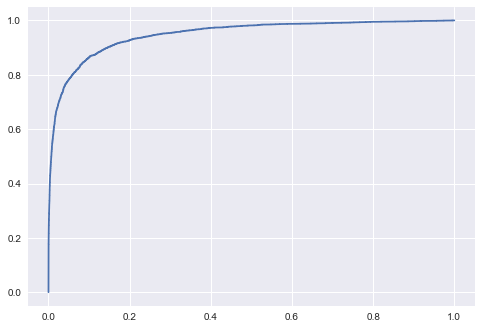

In [70]:
a = metrics.roc_curve(y_test, gs_nb_toxic.predict_proba(x_test)[:,1])
plt.plot(a[0],a[1])
plt.show()

**Train multipyl classifiers**

issue:
  - fixed  <s>is_stop dose not work with en_core_web_lg, works with en_core_web_sm</s>  
  - is_oov dose not work with en_core_web_sm, works with en_core_web_lg

notes:
 - keep -PRON-
 - ngrams?
 - vector from en_core_web_lg token?
 - other tokenizer?
 - tfidf with analyzer=char
 
 
   

data: 
   - v1. en_core_web_lg, nlp.pip, is_stop dose not work with lg model, http address not removed
   - v2. en_core_web_sm, nlp.pip, stop words removed, http address removed, is_oov dose not work with sm model
   - v3. en_core_web_lg, tokenize.pip http address removed, stop word remove fixed, is_oov working
   - v4. en_core_web_lg, tokenize.pip, processed on full set (train and test set combined)

In [32]:
# dose not work, x, y need to have same number of rows

# class ItemSelector(BaseEstimator, TransformerMixin):
#     def __init__(self, key='comment', idx=None):
#         self.key = key
#         self.idx = idx

#     def fit(self, x, y=None):
#         return(self)

#     def transform(self, data_dict):
#         if self.key == 'comment':
#             return(data_dict[self.key])
#         elif self.key == 'features':
#             return(data_dict[self.key][self.idx,:])

# class CommentFeatureExtractor(BaseEstimator, TransformerMixin):
#     '''
#     input data should contain a column of cleaned comments from both train and test set
#     (first n_train samples from train set, the rest from test set), 
#     as well as featurs generated from comments ready for training
#     '''
#     def __init__(self, n_train=None):
#         self.n_train = n_train
        
#     def fit(self, x, y=None):
#         return(self)

#     def transform(self, full_set):
#         data = {}
#         data['comment'] = full_set.cleaned_text
#         data['features'] = full_set.drop('cleaned_text',axis=1)[:self.n_train]
#         return(data)
    
# class MyTfidf(BaseEstimator, TransformerMixin):
#     def __init__(self, max_df=1.0, min_df=1, max_features=None, idx=None, analyzer='word'):
#         self.max_df = max_df
#         self.min_df = min_df
#         self.max_features = max_features
#         self.idx = idx
#         self.analyzer = analyzer
        
#     def fit(self, x, y=None):
#         return(self)
    
#     def transform(self, comments):
#         if self.analyzer == 'word':
#             ngram_range=(1, 1)
#         elif self.analyzer == 'char':
#             ngram_range=(1, 4)
#         Vectorizer_word = TfidfVectorizer(max_df=self.max_df, ngram_range=ngram_range, min_df=self.min_df, 
#                                           max_features=self.max_features, analyzer=self.analyzer,)
#         word_vector = Vectorizer_word.fit_transform(comments)
#         return(word_vector[self.idx])

# # pipeline for training multipule classifiers
# pip = Pipeline([
#             # Extract comments and features columns
#             ('commentfeature', CommentFeatureExtractor()),
            
#             # use FeatureUnion to combine features from tfidf and other already generated features
#             ('union', FeatureUnion(
#                 transformer_list=[
                    
#                     # pipeline to generate features from comments using tfidf analyzed by word
#                     ('tfidf_word', Pipeline([
#                         ('selector', ItemSelector(key='comment')),
#                         ('tfidf', MyTfidf(analyzer='word'))
#                     ])),
                    
#                     # pipeline to generate features from comments using tfidf analyzed by char
#                     ('tfidf_char', Pipeline([
#                         ('selector', ItemSelector(key='comment')),
#                         ('tfidf', MyTfidf(analyzer='char'))
#                     ])),
                    
#                     # get other generated features 
#                     ('other_features', Pipeline([
#                         ('selector', ItemSelector(key='features'))
#                     ]))
#                 ], 
#                 n_jobs=-1,
#                 transformer_weights={
#                     'tfidf_word': 1.0,
#                     'tfidf_char': 1.0,
#                     'other_features': 1.0,
#                 }
#             )),
            
#             # run MNB model on x_train, y_train
#             ('mnb', MultinomialNB())
#             ])

# parameters = {'commentfeature__n_train': [n_train],\
#               'union__tfidf_word__tfidf__max_df': [0.6, 0.7, 0.8, 0.9],\
#               'union__tfidf_word__tfidf__min_df': [0, 10, 30, 100],\
#               'union__tfidf_word__tfidf__idx': [train_idx],\
#               'union__tfidf_char__tfidf__max_df': [1],\
#               'union__tfidf_char__tfidf__min_df': [0],\
#               'union__tfidf_char__tfidf__idx': [train_idx],\
#               'union__other_features__selector__idx': [train_idx],\
#               'nb__alpha': [1, 0.3, 0.1, 0.03, 0.01, 0.003]}
# nb_toxic = GridSearchCV(pip, parameters, n_jobs=-1, scoring = 'roc_auc', verbose=1)
# nb_toxic.fit(full_set.drop(['comment_text', 'id', 'identity_hate', 'insult', 'obscene', 'severe_toxic', 'threat'], 
#                            axis=1),
#             y_train)